In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical



In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


In [3]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential([
    # First Convolutional Block
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Second Convolutional Block
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Third Convolutional Block
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Dropout(0.4),

    # Flattening and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)





Epoch 1/10


1875/1875 [==============================] - 17s 8ms/step - loss: 0.2671 - accuracy: 0.9168 - val_loss: 0.0475 - val_accuracy: 0.9850
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0960 - accuracy: 0.9721 - val_loss: 0.0316 - val_accuracy: 0.9893
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0771 - accuracy: 0.9773 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0625 - accuracy: 0.9822 - val_loss: 0.0313 - val_accuracy: 0.9899
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0582 - accuracy: 0.9833 - val_loss: 0.0260 - val_accuracy: 0.9914
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0520 - accuracy: 0.9844 - val_loss: 0.0237 - val_accuracy: 0.9930
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0508 - accuracy: 0.9853 - val_loss: 0.0233 - v

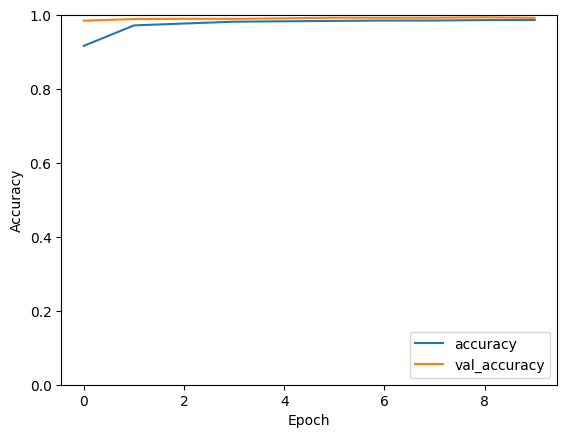

In [4]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [5]:
def create_adversarial_pattern(input_image, input_label):
    input_image = tf.convert_to_tensor(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.categorical_crossentropy(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

epsilon = 0.09
index = 0
image = x_test[index:index+1]
label = y_test[index:index+1]

perturbations = create_adversarial_pattern(image, label)
adv_image = image + epsilon * perturbations
adv_image = tf.clip_by_value(adv_image, 0, 1)


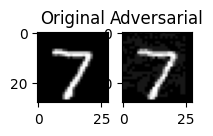

In [6]:
plt.figure(figsize=(2, 2))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image[0, :, :, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Adversarial")
plt.imshow(adv_image[0, :, :, 0], cmap='gray')
plt.show()


In [7]:
labels = np.argmax(model.predict(adv_image), axis=1)
print(f"Original Label: {np.argmax(label)}")
print(f"Adversarial Label: {labels[0]}")



1/1 [==============================] - 0s 126ms/step
Original Label: 7
Adversarial Label: 7


In [8]:
adv_data = x_train[:1000] + epsilon * create_adversarial_pattern(x_train[:1000], y_train[:1000])
adv_data = tf.clip_by_value(adv_data, 0, 1)

combined_images = np.concatenate([x_train, adv_data], axis=0)
combined_labels = np.concatenate([y_train, y_train[:1000]], axis=0)

model.fit(combined_images, combined_labels, epochs=5, validation_data=(x_test, y_test))



Epoch 1/5
1907/1907 [==============================] - 18s 9ms/step - loss: 0.0437 - accuracy: 0.9874 - val_loss: 0.0311 - val_accuracy: 0.9906
Epoch 2/5
1907/1907 [==============================] - 17s 9ms/step - loss: 0.0454 - accuracy: 0.9865 - val_loss: 0.0259 - val_accuracy: 0.9913
Epoch 3/5
1907/1907 [==============================] - 17s 9ms/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0225 - val_accuracy: 0.9936
Epoch 4/5
1907/1907 [==============================] - 17s 9ms/step - loss: 0.0416 - accuracy: 0.9880 - val_loss: 0.0234 - val_accuracy: 0.9935
Epoch 5/5
1907/1907 [==============================] - 17s 9ms/step - loss: 0.0418 - accuracy: 0.9882 - val_loss: 0.0257 - val_accuracy: 0.9926


In [9]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy on original test data: {accuracy}")

adv_test = x_test + epsilon * create_adversarial_pattern(x_test, y_test)
adv_test = tf.clip_by_value(adv_test, 0, 1)
loss, accuracy = model.evaluate(adv_test, y_test)
print(f"Accuracy on adversarial test data: {accuracy}")


313/313 [==============================] - 1s 3ms/step - loss: 0.0257 - accuracy: 0.9926
Accuracy on original test data: 0.9926000237464905
313/313 [==============================] - 1s 3ms/step - loss: 0.3071 - accuracy: 0.9230
Accuracy on adversarial test data: 0.9229999780654907


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer confusion matrix visualization
# Predictions on original test data
original_preds = np.argmax(model.predict(x_test), axis=1)
true_labels = np.argmax(y_test, axis=1)

# Predictions on adversarial test data
adv_test_preds = np.argmax(model.predict(adv_test), axis=1)


313/313 [==============================] - 1s 3ms/step


In [11]:
# Confusion matrix for original test data
conf_matrix_original = confusion_matrix(true_labels, original_preds)

# Confusion matrix for adversarial test data
conf_matrix_adv = confusion_matrix(true_labels, adv_test_preds)


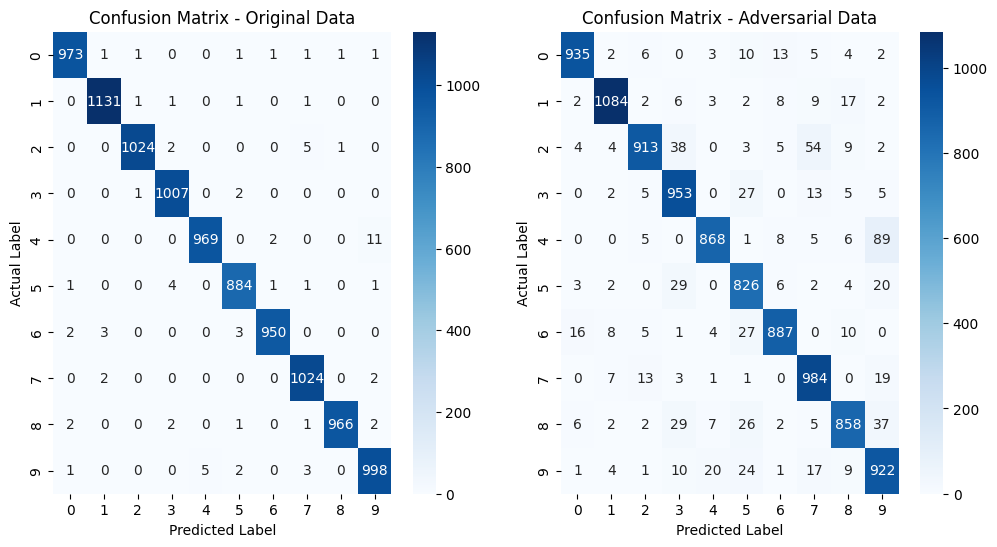

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_original, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - Original Data")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_adv, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - Adversarial Data")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()
